In [1]:
import sys
sys.path.append('../pouakai')
from core import *
%matplotlib widget
from astropy.stats import sigma_clip
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

In [2]:
hdu = fits.open('A6309-12932zephyr-R-4_cal.fits.gz')
hdu = fits.open('A6524-lsst4-R-3_cal.fits.gz')
#hdu = fits.open('A7312-yse415Ba-R-3_cal.fits.gz')
#hdu = fits.open('A7238-yse257Aa-R-3_cal.fits.gz')
#hdu = fits.open('A6385-12932zephyr-V-3_cal.fits.gz')

hduf = fits.open('F5857-121-R-m-3.fits.gz')
flat = hduf[0].data
f = flat / np.nanmedian(flat)
e = hduf[1].data

In [3]:
image = hdu[0].data
mask = hdu[1].data
header = hdu[0].header
wcs = WCS(header)


close sources
no matches  0


close sources
no matches  0


close sources
no matches  0


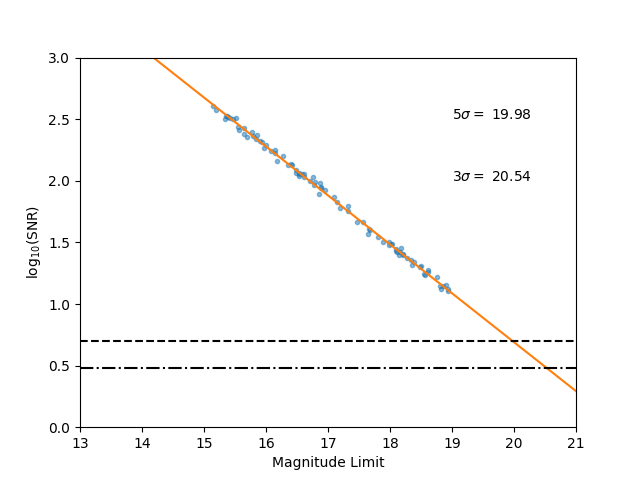

In [4]:
fig, ax = plt.subplots()
orig = ap_photom(data=image,wcs=wcs, header=header,mask =mask,
                threshold=5,cal_model='ckmodel',ax=ax,brightlim=15,rescale=False,plot=False)
cal = ap_photom(data=image,wcs=wcs, header=header,mask =mask,
                    threshold=5,cal_model='ckmodel',ax=ax,brightlim=15)

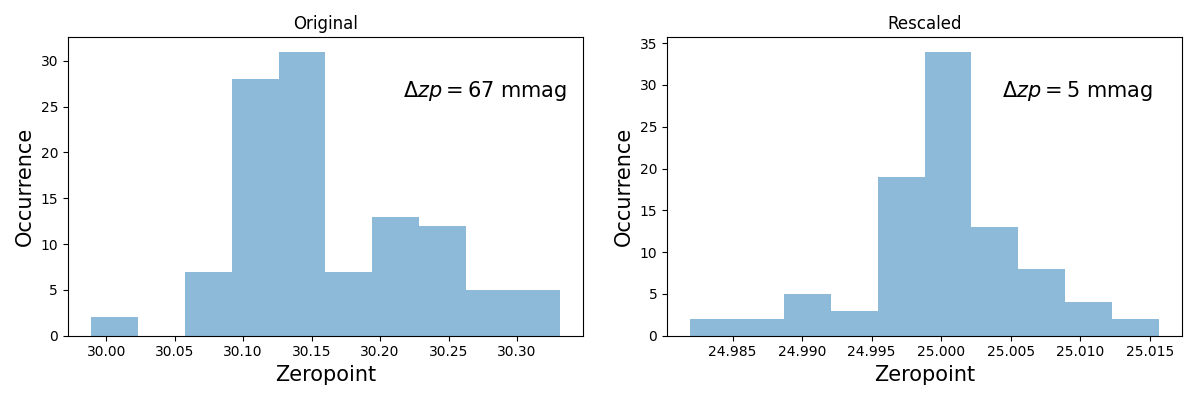

In [6]:
ind = np.isfinite(cal.zps)#~sigma_clip(cal.zps,).mask
std = np.nanstd(cal.zps[ind])
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Original')
plt.hist(orig.zps,alpha=0.5)
plt.ylabel('Occurrence',fontsize = 15)
plt.xlabel(r'Zeropoint',fontsize = 15)
std = np.nanstd(orig.zps)
plt.text(s=r'$\Delta zp={}$ mmag'.format(int(std*1e3)),x=0.65,y=0.8,fontsize=15,transform=plt.gca().transAxes)

plt.subplot(122)
plt.title('Rescaled')
plt.hist((cal.zps[ind]),alpha=0.5)
plt.ylabel('Occurrence',fontsize = 15)
plt.xlabel(r'Zeropoint',fontsize = 15)
std = np.nanstd(cal.zps)
plt.text(s=r'$\Delta zp={}$ mmag'.format(int(std*1e3)),x=0.65,y=0.8,fontsize=15,transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig('new_zp_dist.png')

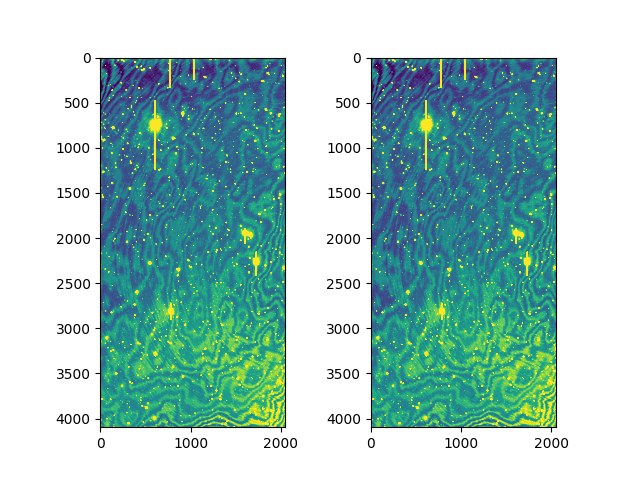

In [14]:
plt.figure()
plt.subplot(121)
l,h = np.nanpercentile(orig.data,(5,95))
plt.imshow(orig.data,vmin=l,vmax=h)
plt.subplot(122)
l,h = np.nanpercentile(cal.data,(5,95))
plt.imshow(cal.data,vmin=l,vmax=h)

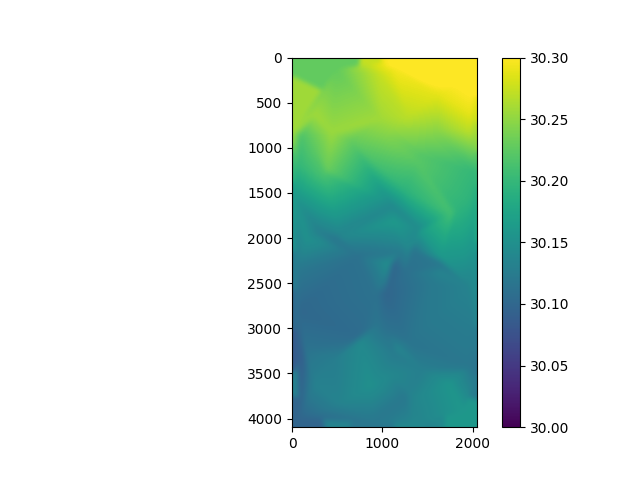

In [30]:
plt.figure()
plt.imshow(cal.zp_surface,vmin=30,vmax=30.3)
plt.colorbar()

In [18]:
ra = orig.sauron.system_cat['ra'].values
dec = orig.sauron.system_cat['dec'].values
c = SkyCoord(ra,dec, unit="deg")
x,y = wcs.all_world2pix(ra,dec,0)

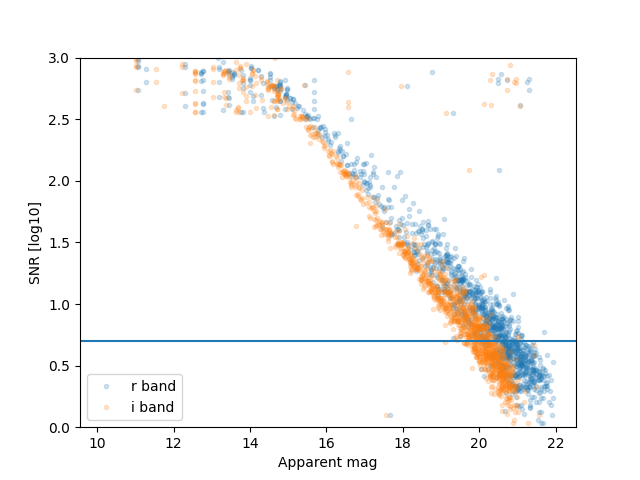

In [19]:
plt.figure()
plt.plot(cal.sauron.cat_mags['r'],np.log10(cal.ap_photom['snr']),'.',alpha=0.2,label='r band')
plt.plot(cal.sauron.cat_mags['i'],np.log10(cal.ap_photom['snr']),'.',alpha=0.2,label='i band')
plt.axhline(np.log10(5))
plt.ylim(0,3)
plt.ylabel('SNR [log10]')
plt.xlabel('Apparent mag')
plt.legend()

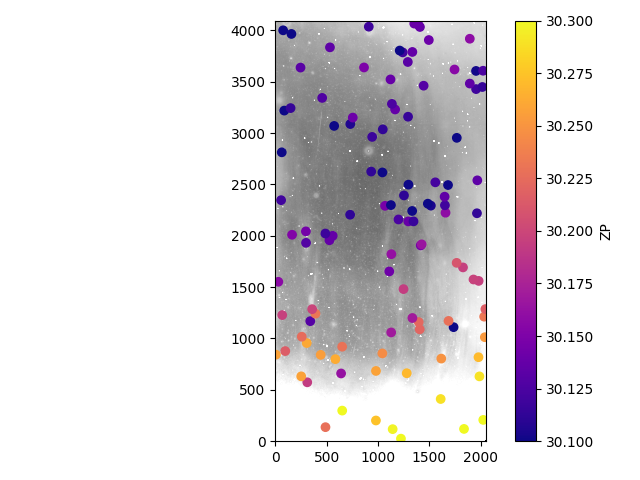

In [22]:
plt.figure()
#plt.imshow((image-cal.data_median)*np.nan,vmin=0,vmax=100,origin='lower')
plt.imshow(1/f,vmin=0.8,vmax=1.1,origin='lower',cmap='gray')
plt.scatter(x,y,c=orig.zps,vmin=30.1,vmax=30.3,cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('ZP')
plt.tight_layout()
ax = plt.gca()
ax.set_aspect('equal')
plt.savefig('test_zp_dist.png',bbox_inches='tight')

In [143]:
np.nanstd(cal.zps+test[y.astype(int),x.astype(int)])

0.07723485053648098

In [28]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

def Fit_surface(cal,mask,smoother=100):
    ind = np.isfinite(cal.zps)
    if mask is not None:
        ind = ind & mask
    x_data = (cal.ap_photom['xcenter'].values[ind] + 0.5).astype(int)
    y_data = (cal.ap_photom['ycenter'].values[ind] + 0.5).astype(int)
    z_data = cal.zps[ind]
    
    zpimage = np.zeros_like(cal.data)
    zpimage[y_data,x_data] = z_data
    zpimage[zpimage==0] = np.nan
    #zpimage[cut.mask] = np.nan

    x = np.arange(0, cal.data.shape[1])
    y = np.arange(0, cal.data.shape[0])
    arr = np.ma.masked_invalid(zpimage)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~arr.mask]
    y1 = yy[~arr.mask]
    newarr = arr[~arr.mask]

    estimate = griddata((x_data, y_data), newarr.ravel(),
                                (xx, yy),method='linear')
    bitmask = np.zeros_like(cal.data,dtype=int)
    bitmask[np.isnan(estimate)] = 128 | 4
    nearest = griddata((x1, y1), newarr.ravel(),
                                (xx, yy),method='nearest')

    estimate[np.isnan(estimate)] = nearest[np.isnan(estimate)]

    estimate = gaussian_filter(estimate,smoother)

    return estimate, bitmask

In [29]:
tmp,_ = Fit_surface(orig,None,smoother=200)
x_data = (orig.ap_photom['xcenter'].values + 0.5).astype(int)
y_data = (orig.ap_photom['ycenter'].values + 0.5).astype(int)
diff = (orig.zps - tmp[y_data.astype(int),x_data.astype(int)])
cut = ~sigma_clip(diff,sigma=2).mask
estimate,_ = Fit_surface(orig,cut,smoother=25)

<ipython-input-35-d6e454669c24>:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
<ipython-input-35-d6e454669c24>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


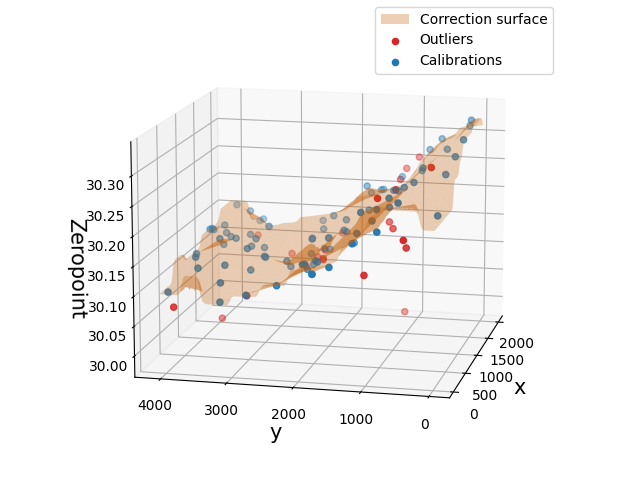

In [35]:
ind = np.isfinite(orig.zps)
x_data = (orig.ap_photom['xcenter'].values + 0.5).astype(int)
y_data = (orig.ap_photom['ycenter'].values + 0.5).astype(int)
z_data = orig.zps

zpimage = np.zeros_like(orig.data)
zpimage[y_data,x_data] = z_data
zpimage[zpimage==0] = np.nan
#zpimage[cut.mask] = np.nan

x = np.arange(0, orig.data.shape[1])
y = np.arange(0, orig.data.shape[0])
arr = np.ma.masked_invalid(zpimage)
xx, yy = np.meshgrid(x, y)

fig = plt.figure()
# setup 3d object
ax = Axes3D(fig)
# plot surface
#ax.plot_surface(xx, yy, tmp,alpha=0.5,color='C1')
surf = ax.plot_surface(xx, yy, estimate,alpha=0.3,color='C1',label='Correction surface')
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
# plot input data
ax.scatter(x_data[~cut], y_data[~cut], orig.zps[~cut], color='C3',label='Outliers')
ax.scatter(x_data[cut], y_data[cut], orig.zps[cut], color='C0',label='Calibrations')
# set plot descriptions
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('y ',fontsize=15)
ax.set_zlabel('Zeropoint',fontsize=15)
ax.legend()
ax.view_init(elev=13.,azim=-167)
plt.tight_layout()

## Assume i band is a good match and calc zp

In [8]:
i = cal.sauron.cat_mags['i'].values
counts = cal.ap_photom['counts'].values
x = cal.ap_photom['xcenter'].values
y = cal.ap_photom['ycenter'].values

In [6]:
testzp = i + 2.5*np.log10(counts)

(array([  1.,   0.,   1.,   1.,  16., 135.,  71.,   7.,   5.,   5.]),
 array([19.72507045, 20.93845194, 22.15183343, 23.36521492, 24.57859641,
        25.7919779 , 27.00535939, 28.21874088, 29.43212237, 30.64550386,
        31.85888535]),
 <BarContainer object of 10 artists>)

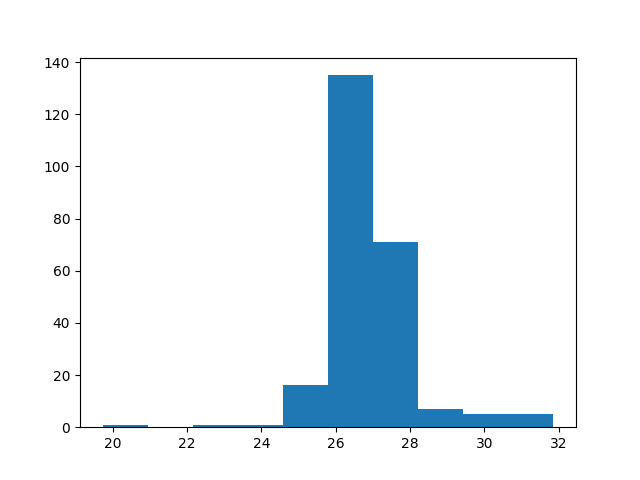

In [10]:
plt.figure()
plt.hist(testzp)

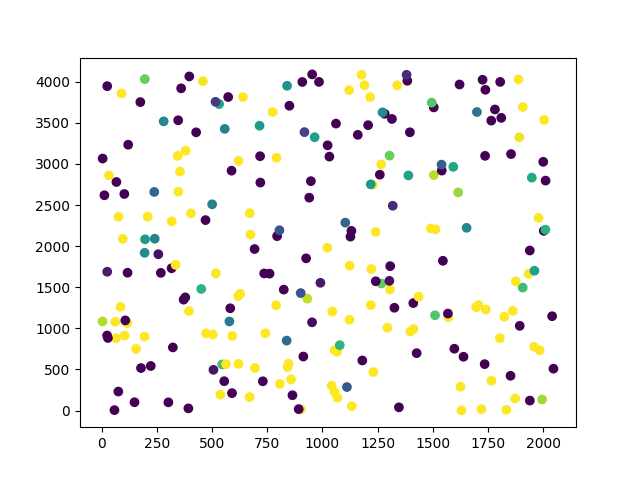

In [13]:
med = np.nanmedian(testzp)
plt.figure()
plt.scatter(x,y,c=testzp,vmin=med-.1,vmax=med+.1)